In [0]:
#Import necessary packages
import numpy as np
import pandas as pd
from PIL import Image
import json
import cv2
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from skimage import data, exposure

In [4]:
data = pd.read_csv('input.csv')
data.shape

(35887, 3)

In [5]:
data.head()

,emotion (label),pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
data.rename(columns={'emotion (label)':'emotion'}, inplace=True)

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
print('Number of pixels for a sample:')
print(len(data.pixels[0].split(' ')))

Number of pixels for a sample:
2304


In [9]:
#check usage values
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [10]:
#check target labels
emotion_map = {0: 'Not happy', 1: 'Happy'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Not happy,26898
1,Happy,8989


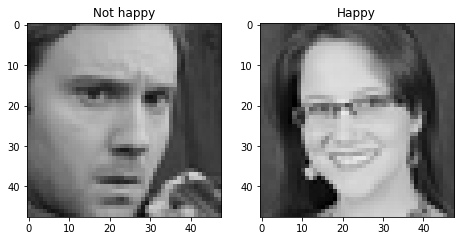

In [11]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,3):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

### Pre Processing

In [12]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
#initilize parameters
num_classes = 2 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [15]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


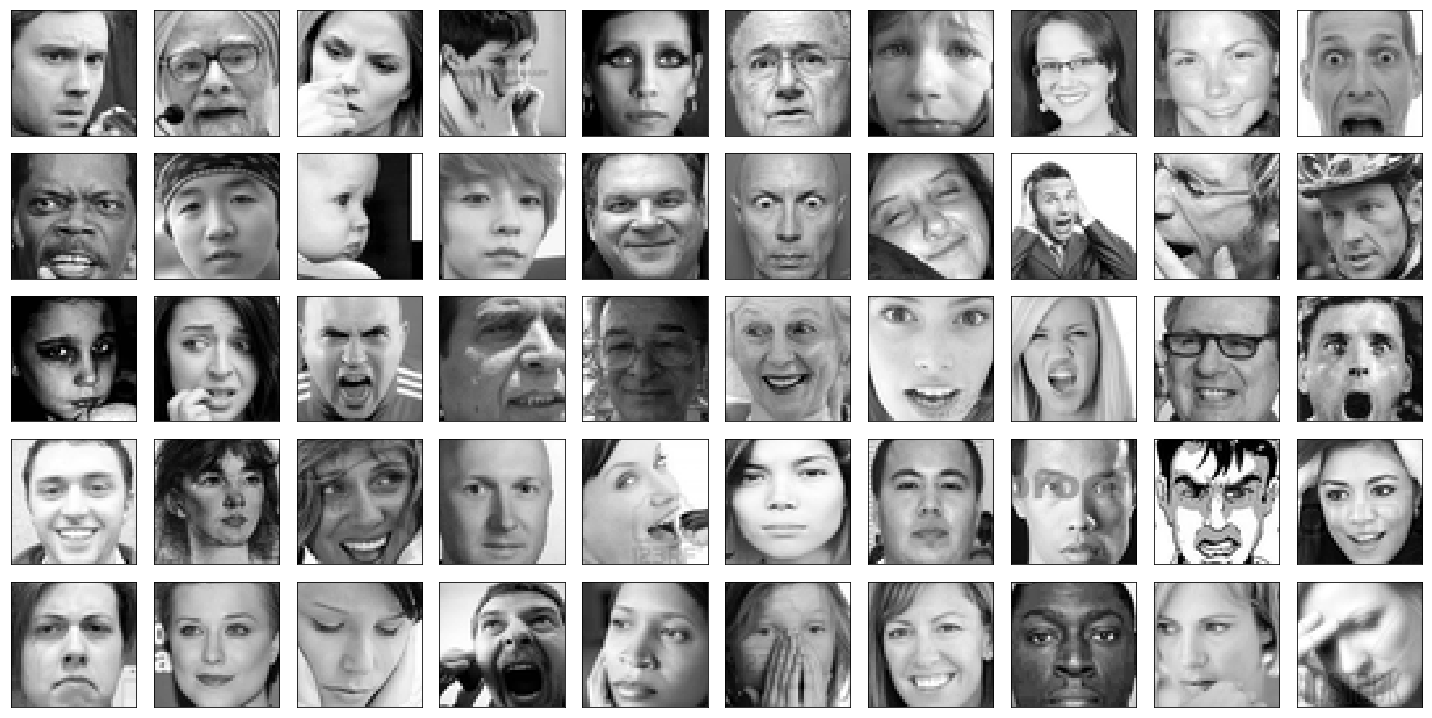

In [16]:
import matplotlib
import matplotlib.pyplot as plt

def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,50, train_X)

In [17]:
ppc = 8
hog_images_train = []
hog_features_train = []
for image in train_X:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualise=True, multichannel = True)
    hog_images_train.append(hog_image)
    hog_features_train.append(fd)

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [18]:
ppc = 8
hog_images_val = []
hog_features_val = []
for image in val_X:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualise=True, multichannel = True)
    hog_images_val.append(hog_image)
    hog_features_val.append(fd)

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [19]:
ppc = 8
hog_images_test = []
hog_features_test = []
for image in test_X:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualise=True, multichannel = True)
    hog_images_test.append(hog_image)
    hog_features_test.append(fd)

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [20]:
print(len(hog_features_train))
print(len(hog_features_val))
print(len(hog_features_test))

28709
3589
3589


1152


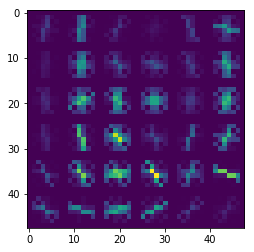

In [21]:
plt.imshow(hog_images_train[51])
print(len(hog_features_train[51]))

1152


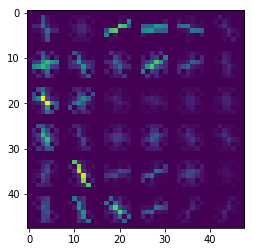

In [22]:
plt.imshow(hog_images_val[1])
print(len(hog_features_val[1]))

1152


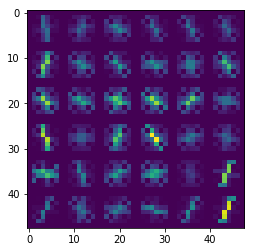

In [23]:
plt.imshow(hog_images_test[0])
print(len(hog_features_test[0]))

In [24]:
train_labels =  np.array(data_train['emotion']).reshape(len(data_train['emotion']),1)
len(train_labels)

28709

In [25]:
val_labels =  np.array(data_val['emotion']).reshape(len(data_val['emotion']),1)
len(val_labels)

3589

In [26]:
test_labels =  np.array(data_test['emotion']).reshape(len(data_test['emotion']),1)
len(test_labels)

3589

In [0]:
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

In [0]:
clf = svm.SVC()
hog_features_train = np.array(hog_features_train)
data_frame_train = np.hstack((hog_features_train,train_labels))
np.random.shuffle(data_frame_train)

In [0]:
clf = svm.SVC()
hog_features_val = np.array(hog_features_val)
data_frame_val = np.hstack((hog_features_val,val_labels))
np.random.shuffle(data_frame_val)

In [0]:
clf = svm.SVC()
hog_features_test = np.array(hog_features_test)
data_frame_test = np.hstack((hog_features_test,test_labels))
np.random.shuffle(data_frame_test)

In [31]:
x_train, x_test = data_frame_train[:,:-1],  data_frame_test[:,:-1]
y_train, y_test = data_frame_train[:,-1:].ravel() , data_frame_test[:,-1:].ravel()

clf.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = clf.predict(x_test)

In [33]:
print("Accuracy: ",(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy:  0.7550849818891056


              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      2710
         1.0       0.00      0.00      0.00       879

    accuracy                           0.76      3589
   macro avg       0.38      0.50      0.43      3589
weighted avg       0.57      0.76      0.65      3589



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
